In [1]:
from src.config import Config
from src.prompt import Prompt
from src import memory

import openai

In [2]:
cfg = Config()
memory = memory.Memory()

In [3]:
def initialize():
    if cfg.openai_api_key == "None":
        print("OpenAI API key not found. Please set it in .env")
        exit(1)
    else:
        openai.api_key = cfg.openai_api_key

    # print(f"OpenAI API key: {openai.api_key}")

initialize()

In [4]:
# goal = "Write a Python script to print the square of the numbers from 0 to 9 (inclusive) to the system console"
# goal = "Write a Python script to print \"Hello world\" and the current date to the system console"
# goal = "Make infinite money"
# goal = "Write text to a file and then open notepad to display the file"
# goal = "Disable hibernation and remove the hibernation sys file"
# goal = "Open Google Chrome and navigate to youtube.com, wait 3 seconds, scroll down, then close the window"
# goal = "Find the first 10 prime numbers and open them in Notepad"

print()
goal = input("What would you like me to do? > ")

print()
print("Thinking...")

messages=[
        {"role": "system", "content": "You are an agent in the world."},
        {"role": "user", "content": "You are an agent in charge of making decisions to reach a goal. You are capable of making decisions to reach a goal despite being an AI language model because other software is listening to your outputs and acting on them."},
        {"role": "assistant", "content": "Great, what is our goal?"},
        {"role": "user", "content": goal},
        {"role": "user", "content": "Can you write a Python script to accomplish this goal? Do NOT do so, just answer with (y/n)"},
    ]



Thinking...


In [5]:
llm_response = openai.ChatCompletion.create(
    model=cfg.model,
    messages=messages,
    max_tokens=1
)

In [6]:
memory.extend_log(messages)

In [7]:
llm_response_msg = dict(llm_response.choices[0].message)
memory.append_log(llm_response_msg)

In [8]:
if memory.get_last_log_entry(role="assistant")["content"].lower() == "y":
    prompt = Prompt()

    prompt.extend_log(memory.get_log())
    
    user_response_msgs = {"role": "user", "content": "Please write the script. Enclose the script in Markdown code tags. Do not include any explanation, only include code."}
    prompt.append_log(user_response_msgs)

    llm_response = prompt.send()
    llm_response_msg = dict(llm_response.choices[0].message)

    memory.append_log(user_response_msgs)
    memory.append_log(llm_response_msg)

else:
    print("This request is too complex for now. Expect this capability to be implemented in the future.")
    exit(0)

In [9]:
def parse_code(llm_response_msg):
    CODE_DELIM = "```"
    code_start_idx = llm_response_msg.find(CODE_DELIM)

    code = llm_response_msg[code_start_idx+len(CODE_DELIM):llm_response_msg.find(CODE_DELIM, code_start_idx+len(CODE_DELIM))]

    LANG_STR = "python"
    if code.startswith(LANG_STR):
        code = code[code.find(LANG_STR)+len(LANG_STR):]
    
    return str(code)

In [10]:
import importlib
import subprocess
import sys


def get_import_dict(code):
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    import_dict = {}

    for line in code.splitlines():

        try:
            if line.startswith("import"):
                module_name = line.split(" ")[1]
                import_dict[module_name] = importlib.import_module(module_name)

            elif line.startswith("from"):
                module_name = line.split(" ")[1]
                import_dict[module_name] = importlib.import_module(module_name)

                attr_strs = line[line.find("import")+len("import"):].split(",")
                attr_strs = [attr_str.strip() for attr_str in attr_strs]

                for attr_str in attr_strs:
                    import_dict[module_name + "." + attr_str] = importlib.import_module(module_name + "." + attr_str)
                    
        except ModuleNotFoundError as e:
            e_str = str(e)

            modname_begin_idx = e_str.find("'") + 1
            modname_end_idx = e_str.find("'", modname_begin_idx)

            modname = e_str[modname_begin_idx:modname_end_idx]

            dot_idx = modname.find(".")
            modname = modname[0:dot_idx if dot_idx != -1 else len(modname)]

            print()
            will_install = input(f"{modname} is required, do you want to install it? (y/n) > ").lower() == "y"

            if will_install:
                install(modname.replace("_", "-"))
            else:
                exit(0)

    return import_dict

In [11]:
import traceback

def exec_code(code, is_main_script=True):
    import_dict = get_import_dict(code)
        
    print()
    print(f"code:\n{code}")
    print()
    print("executing...")

    try:
        exec(code, import_dict)
        return True, "successful", is_main_script
    
    except Exception as e:
        return False, traceback.format_exc(), is_main_script

In [12]:
def code_proceed_query(code):
    print()
    print("I want to execute this code:")
    print(code)
    print()
    proceed = input("Proceed? (y/n) > ")

    if proceed.lower() != "y":
        exit(0)

In [13]:
llm_response_msg = memory.get_last_log_entry(role="assistant")["content"]
code = parse_code(llm_response_msg)

In [14]:
code_proceed_query(code)


I want to execute this code:

import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(6*30)

tesla_data = pdr.get_data_yahoo('TSLA', start=start_date, end=end_date)

plt.figure(figsize=(10, 5))
plt.plot(tesla_data['Close'], label='Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.title('TESLA Stock Price for the Last 6 Months')
plt.legend()
plt.show()




In [15]:
def continuous_prompt(user_response_msgs, memory):
    prompt = Prompt()
    prompt.extend_log(memory.get_log())

    prompt.extend_log(user_response_msgs)

    llm_response = prompt.send()
    llm_response_msg = dict(llm_response.choices[0].message)

    memory.extend_log(user_response_msgs)
    memory.append_log(llm_response_msg)

    llm_response_msg = memory.get_last_log_entry(role="assistant")["content"]

    return llm_response_msg


code:

import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt

end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(6*30)

tesla_data = pdr.get_data_yahoo('TSLA', start=start_date, end=end_date)

plt.figure(figsize=(10, 5))
plt.plot(tesla_data['Close'], label='Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.title('TESLA Stock Price for the Last 6 Months')
plt.legend()
plt.show()


executing...

iteration: 1
exec_success: False
exec_msg: Traceback (most recent call last):
  File "C:\Users\rodjm\AppData\Local\Temp\ipykernel_10020\1065055955.py", line 12, in exec_code
    exec(code, import_dict)
  File "<string>", line 10, in <module>
  File "c:\Users\rodjm\OneDrive\Documents\AutoGPT\new\LLMind\.venv\Lib\site-packages\pandas_datareader\data.py", line 80, in get_data_yahoo
    return YahooDailyReader(*args, **kwargs).read()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rod

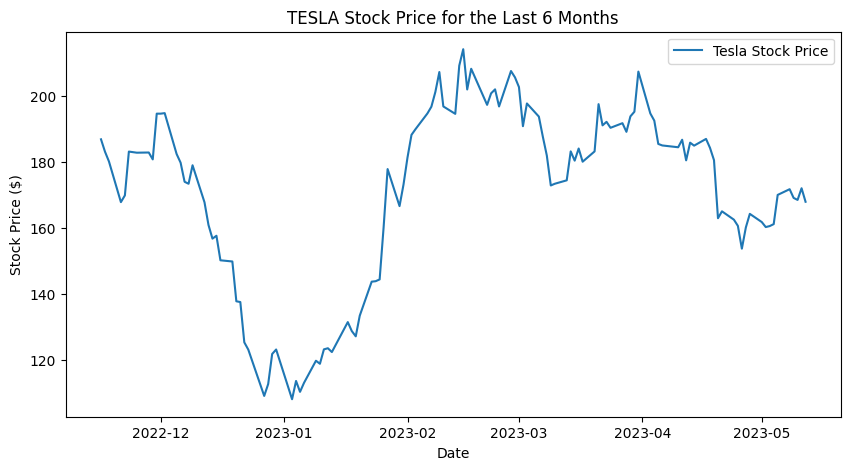


iteration: 2
exec_success: True
exec_msg: successful
exec_is_main_script: True
successful


In [16]:
exec_success, exec_msg, exec_is_main_script = exec_code(code, is_main_script=True)

done = False
iterations = 0

while not done:
    iterations += 1
    
    print()
    print(f"iteration: {iterations}")
    print(f"exec_success: {exec_success}\nexec_msg: {exec_msg}\nexec_is_main_script: {exec_is_main_script}")

    if not exec_success:
        user_response_msgs = [{"role": "user", "content": "Your code produced an error:"},
                            {"role": "user", "content": exec_msg},
                            {"role": "user", "content": "Is this error best fixed with a separate Python script or a revised Python script? Answer 's' for separate, 'r' for revised."}]


        llm_response_msg = continuous_prompt(user_response_msgs, memory).lower()

        while llm_response_msg != "s" and llm_response_msg != "r":
            user_response_msgs = [{"role": "user", "content": "Only 's' or 'r'."}]
            llm_response_msg = continuous_prompt(user_response_msgs, memory).lower()
            
        else:
            if llm_response_msg == "s":
                user_response_msgs = [{"role": "user", "content": "Write a unique Python script to fix this error. Enclose the script in Markdown code tags. Do not include any explanation, only include code."}]

                llm_response_msg = continuous_prompt(user_response_msgs, memory)

                code = parse_code(llm_response_msg)

                code_proceed_query(code)

                exec_success, exec_msg, exec_is_main_script = exec_code(code, is_main_script=False)

            elif llm_response_msg == "r":      
                user_response_msgs = [{"role": "user", "content": "Write a revised version of the main Python script to fix this error. Remember, this Python script is designed to accomplish this goal:"},
                                    {"role": "user", "content": goal},
                                    {"role": "user", "content": "Enclose the script in Markdown code tags. Do not include any explanation, only include code."}]


                llm_response_msg = continuous_prompt(user_response_msgs, memory)

                code = parse_code(llm_response_msg)

                code_proceed_query(code)

                exec_success, exec_msg, exec_is_main_script = exec_code(code, is_main_script=True)

    else:
        if not exec_is_main_script:
                user_response_msgs = [{"role": "user", "content": "With the problem now fixed, write a revised version of the main Python script to fix this error. Remember, this Python script is designed to accomplish this goal:"},
                                    {"role": "user", "content": goal},
                                    {"role": "user", "content": "Enclose the script in Markdown code tags. Do not include any explanation, only include code."}]


                llm_response_msg = continuous_prompt(user_response_msgs, memory)

                code = parse_code(llm_response_msg)

                code_proceed_query(code)

                exec_success, exec_msg, exec_is_main_script = exec_code(code, is_main_script=True)
            
        else:
            done = True
    
else:
    print(exec_msg)